In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv(r"TSLA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


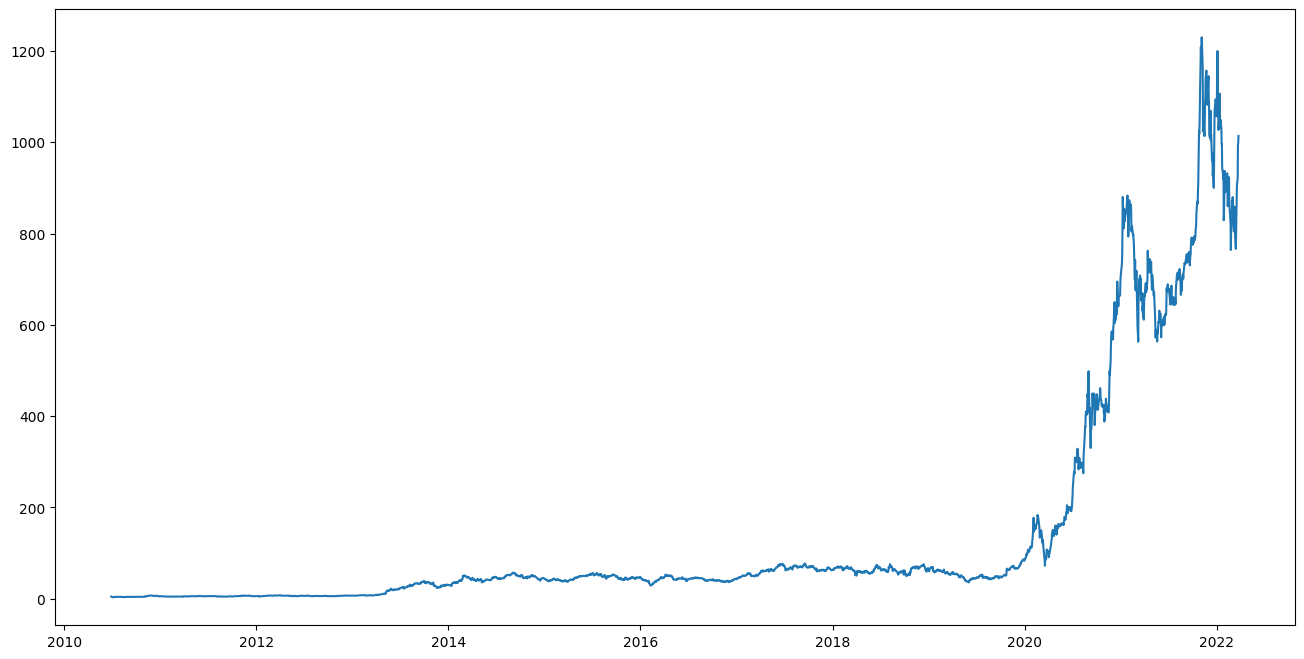

In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [4]:
# Sort the original data
data = df.sort_index(ascending=True, axis=0)

# Initialize a new DataFrame
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

# Populate new_dataset with 'Date' and 'Close' columns
for i in range(0, len(data)):
    new_dataset.iloc[i, 0] = data.iloc[i]['Date']
    new_dataset.iloc[i, 1] = data.iloc[i]['Close']

In [5]:
# Convert 'Date' to datetime format if necessary
new_dataset['Date'] = pd.to_datetime(new_dataset['Date'])

# Set 'Date' as the index
new_dataset.set_index('Date', inplace=True)

# Initialize the scaler and convert dataset to values
scaler = MinMaxScaler(feature_range=(0, 1))
final_dataset = new_dataset.values

# Calculate the index for the 70% training data split
train_size = int(len(final_dataset) * 0.7)

# Define training and testing data
train_data = final_dataset[:train_size, :]
test_data = final_dataset[train_size:, :]

# Scale the data
scaled_data = scaler.fit_transform(final_dataset)

# Prepare training data
x_train_data, y_train_data = [], []
for i in range(60, train_size):
    x_train_data.append(scaled_data[i-60:i, 0])
    y_train_data.append(scaled_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshape x_train_data
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

# Prepare testing data
x_test_data, y_test_data = [], []
for i in range(60, len(test_data)):
    x_test_data.append(scaled_data[train_size + i - 60:train_size + i, 0])
    y_test_data.append(scaled_data[train_size + i, 0])

x_test_data, y_test_data = np.array(x_test_data), np.array(y_test_data)

# Reshape x_test_data
x_test_data = np.reshape(x_test_data, (x_test_data.shape[0], x_test_data.shape[1], 1))

In [7]:
# Define the LSTM model with more layers and Dropout
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model with the Adam optimizer
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with increased epochs and early stopping
history = lstm_model.fit(
    x_train_data, y_train_data, 
    epochs=50, batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping], 
    verbose=2
)

# Prepare test data (assuming 'scaler' and 'valid_data' are defined)
inputs_data = new_dataset[len(new_dataset) - len(test_data) - 60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)
# lstm_model.compile(loss='mean_squared_error',optimizer='adam')

Epoch 1/50
51/51 - 12s - 240ms/step - loss: 9.0291e-05 - val_loss: 2.1230e-05
Epoch 2/50
51/51 - 5s - 95ms/step - loss: 1.2993e-05 - val_loss: 2.4495e-05
Epoch 3/50
51/51 - 5s - 94ms/step - loss: 9.2079e-06 - val_loss: 1.4045e-05
Epoch 4/50
51/51 - 5s - 96ms/step - loss: 8.4438e-06 - val_loss: 1.1649e-05
Epoch 5/50
51/51 - 5s - 94ms/step - loss: 8.6019e-06 - val_loss: 1.2239e-05
Epoch 6/50
51/51 - 5s - 94ms/step - loss: 9.1999e-06 - val_loss: 1.3082e-05
Epoch 7/50
51/51 - 5s - 94ms/step - loss: 8.3613e-06 - val_loss: 1.5008e-05
Epoch 8/50
51/51 - 5s - 96ms/step - loss: 8.4595e-06 - val_loss: 3.0235e-05
Epoch 9/50
51/51 - 5s - 96ms/step - loss: 6.5688e-06 - val_loss: 1.2472e-05
Epoch 10/50
51/51 - 5s - 93ms/step - loss: 6.6106e-06 - val_loss: 1.2152e-05
Epoch 11/50
51/51 - 5s - 94ms/step - loss: 7.0040e-06 - val_loss: 1.9467e-05
Epoch 12/50
51/51 - 5s - 97ms/step - loss: 7.9346e-06 - val_loss: 1.9839e-05
Epoch 13/50
51/51 - 5s - 95ms/step - loss: 6.5399e-06 - val_loss: 1.4108e-05
Epoch 

In [8]:
# Create the test dataset
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create y_test_data
y_test_data = []
for i in range(60, inputs_data.shape[0]):
    y_test_data.append(inputs_data[i, 0])  # The next value after the sequence
y_test_data = np.array(y_test_data)

# Make predictions on the test set
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

# Evaluate on the test set (assuming y_test_data is defined)
mae = mean_absolute_error(y_test_data, predicted_closing_price)

# Print evaluation metrics
print(f"Mean Absolute Error: {mae}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Mean Absolute Error: 343.20183642529264


In [9]:
lstm_model.save("stock_tesla.h5")

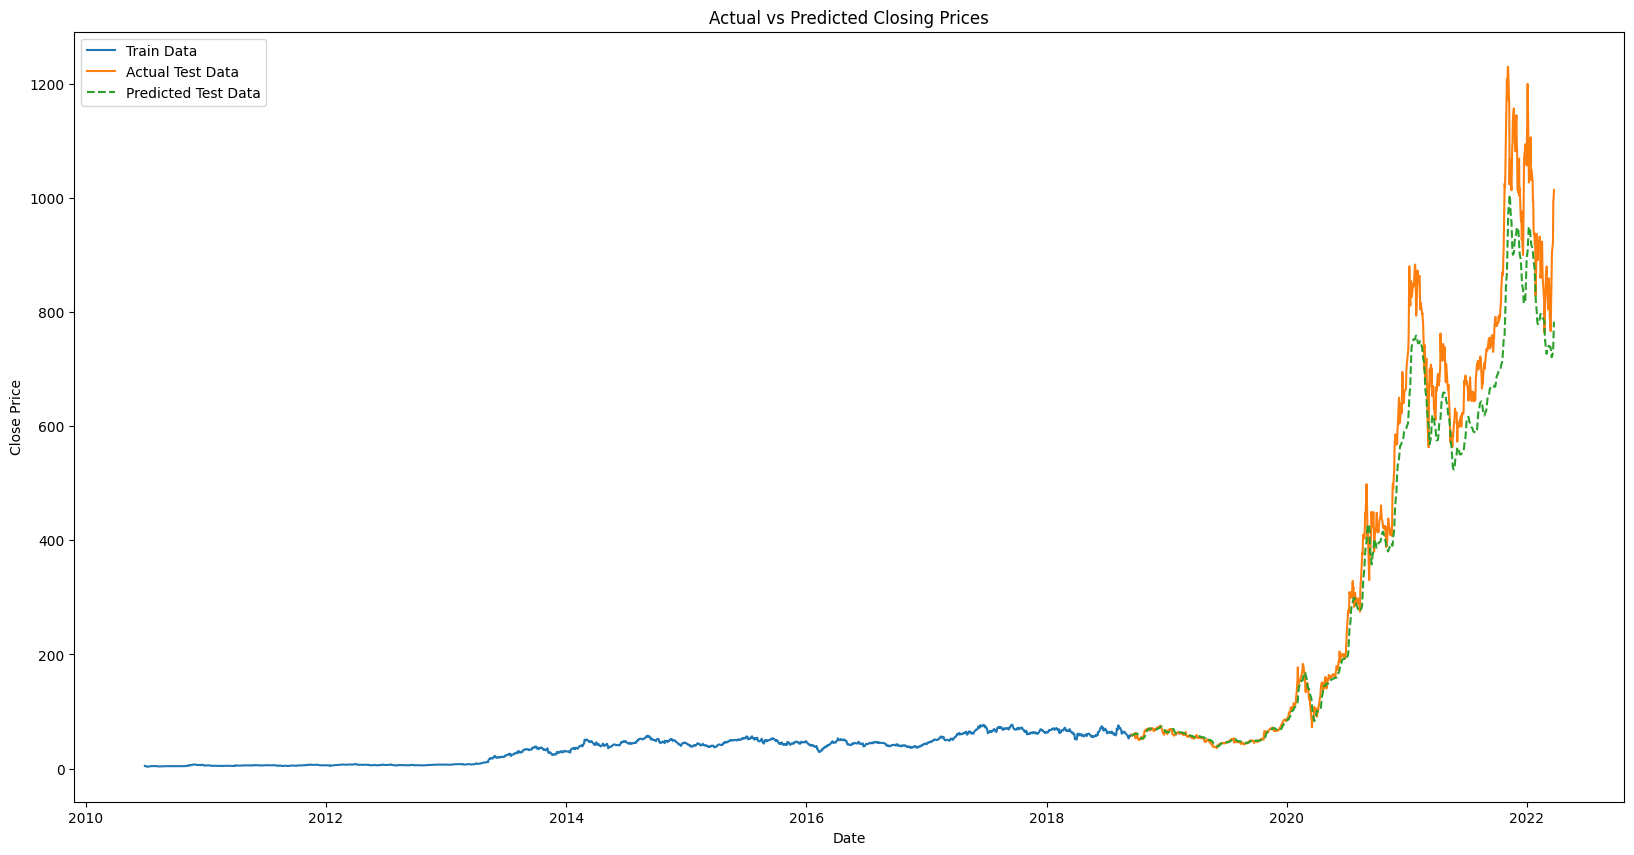

In [10]:
# Calculate the 70% index for training data
train_size = int(len(new_dataset) * 0.7)

# Define training and validation data based on 70/30 split
train_data = new_dataset[:train_size]
test_data = new_dataset[train_size:].copy()  # Make a copy to add predictions without warnings

# Assuming `predicted_closing_price` is already computed
test_data['Predictions'] = predicted_closing_price  # Add predictions to the test data

# Plot the results
plt.plot(train_data["Close"], label="Train Data")
plt.plot(test_data["Close"], label="Actual Test Data")
plt.plot(test_data["Predictions"], label="Predicted Test Data", linestyle="--")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Closing Prices")
plt.show()
